<a href="https://colab.research.google.com/github/zeegy99/backtester/blob/main/Momentum_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Mean Monthly Return: 0.63%
Monthly Volatility: 6.80%
Monthly Sharpe: 0.0930
------------------------------------------------------------
Annualized Return: 7.59%
Annualized Volatility: 23.56%
Annualized Sharpe: 0.3221!

[monthly_returns.png](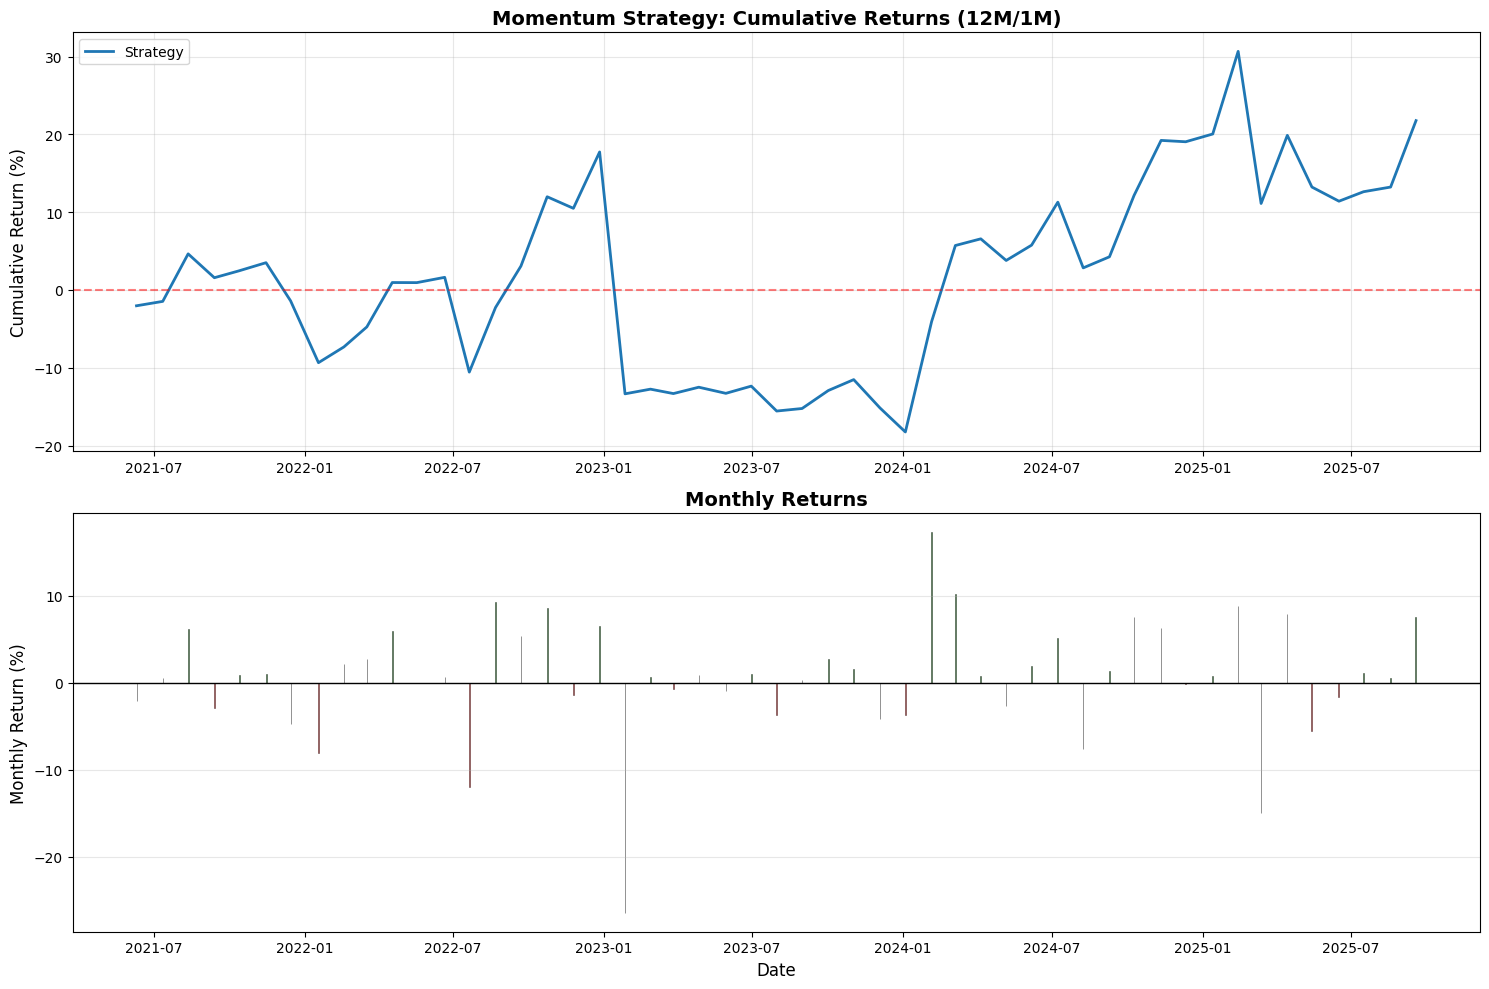)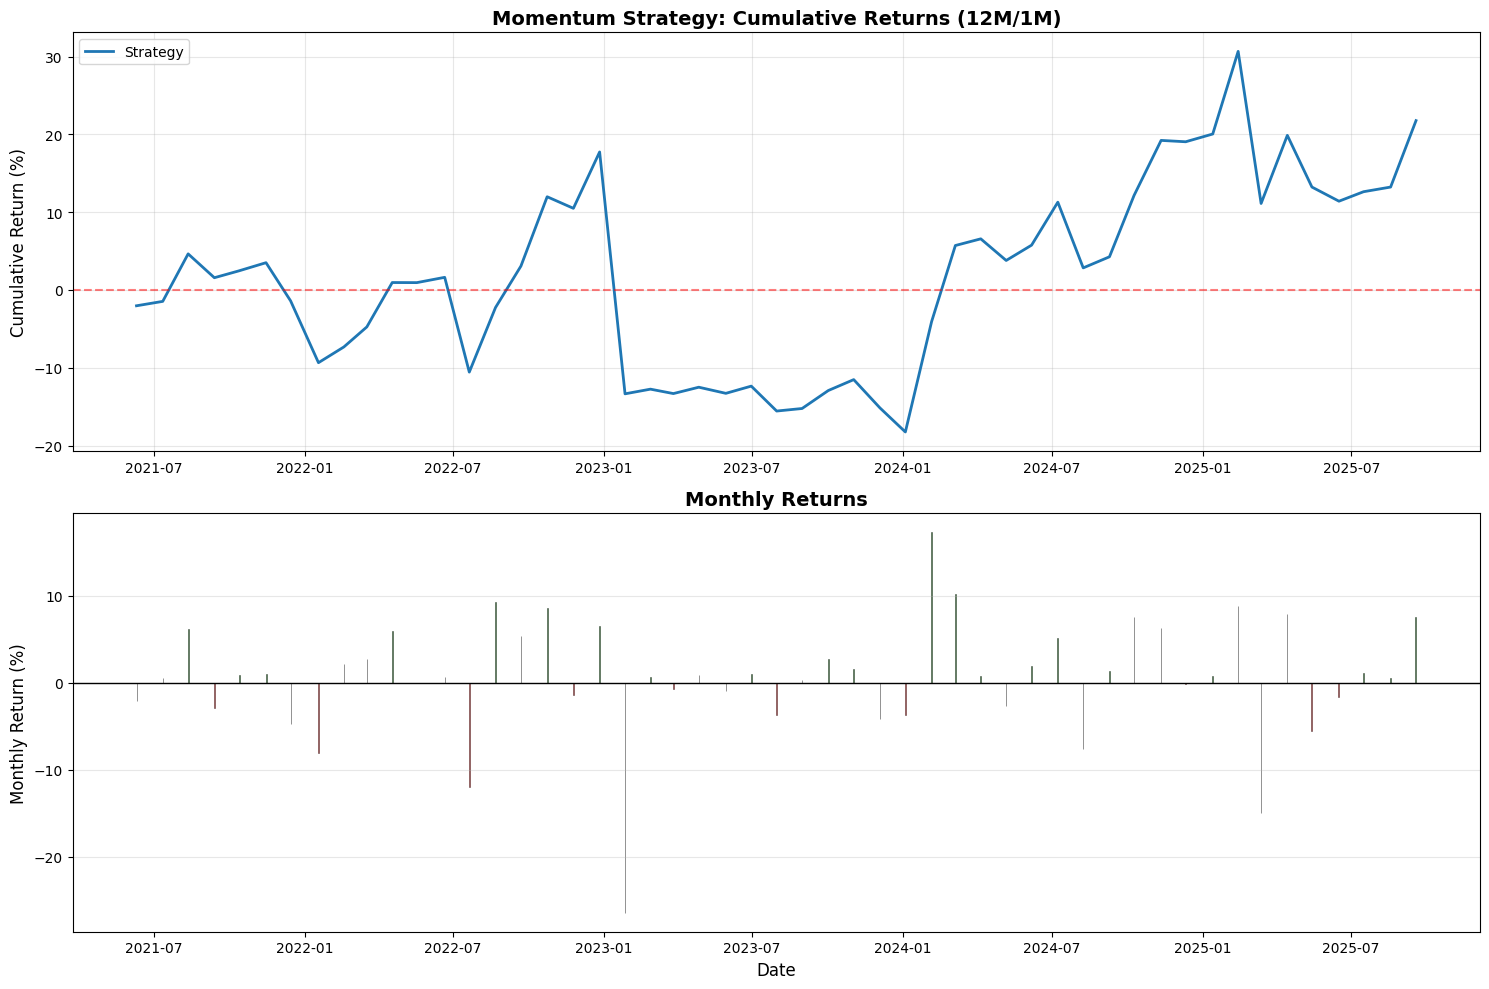

Mean Monthly Return: 0.54%
Monthly Volatility: 4.03%
Monthly Sharpe: 0.1340
------------------------------------------------------------
Annualized Return: 6.47%
Annualized Volatility: 13.94%
Annualized Sharpe: 0.4642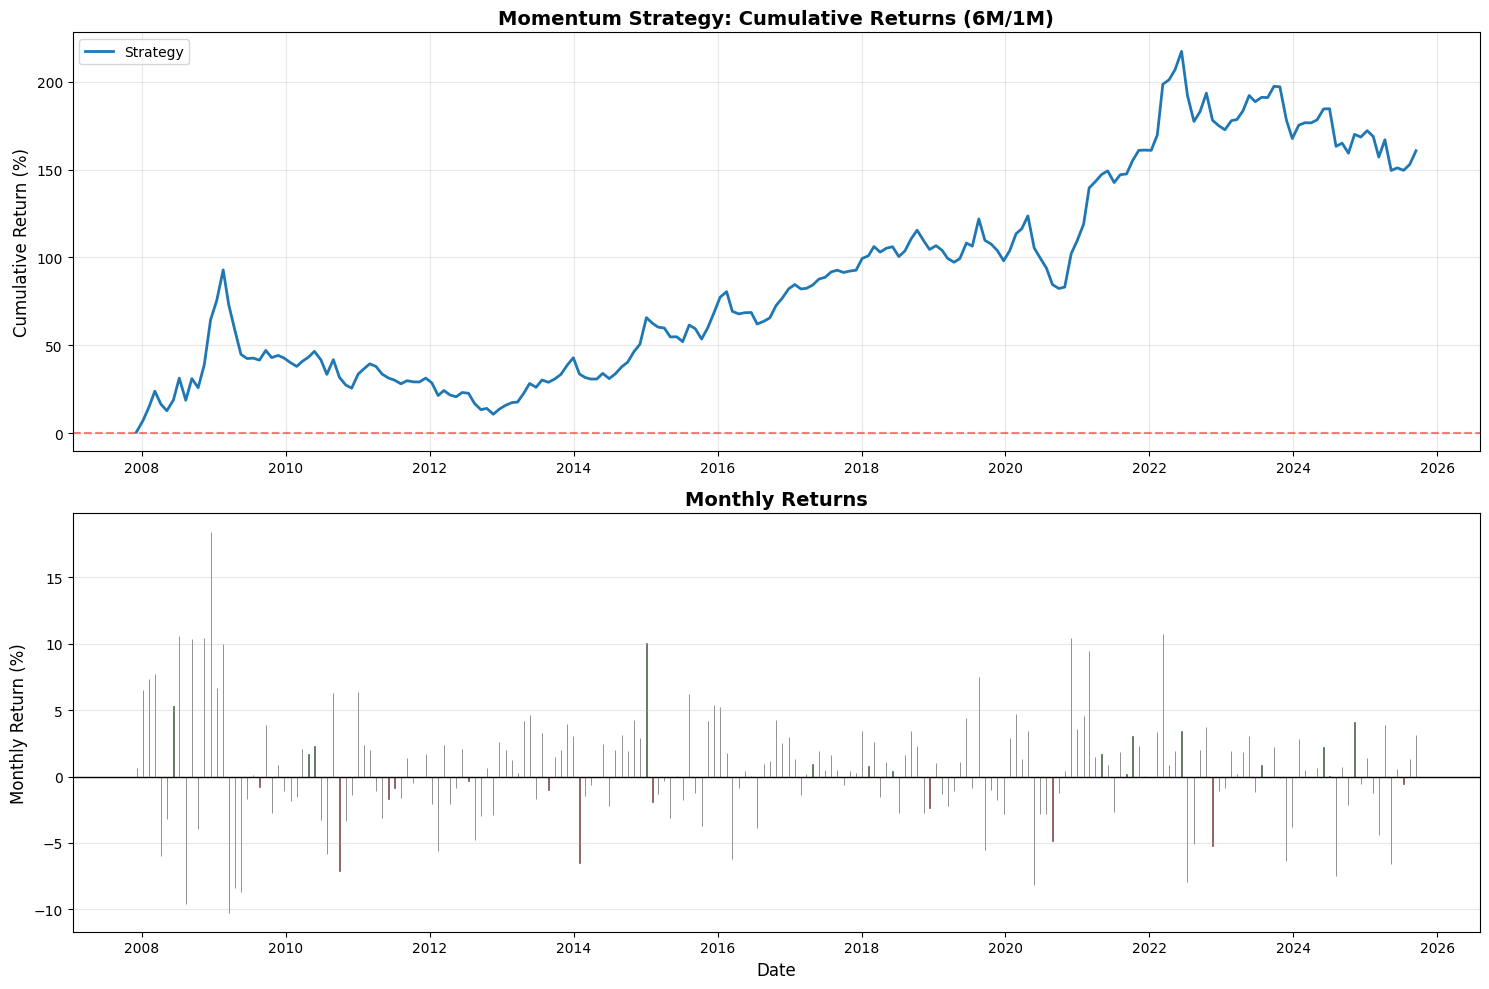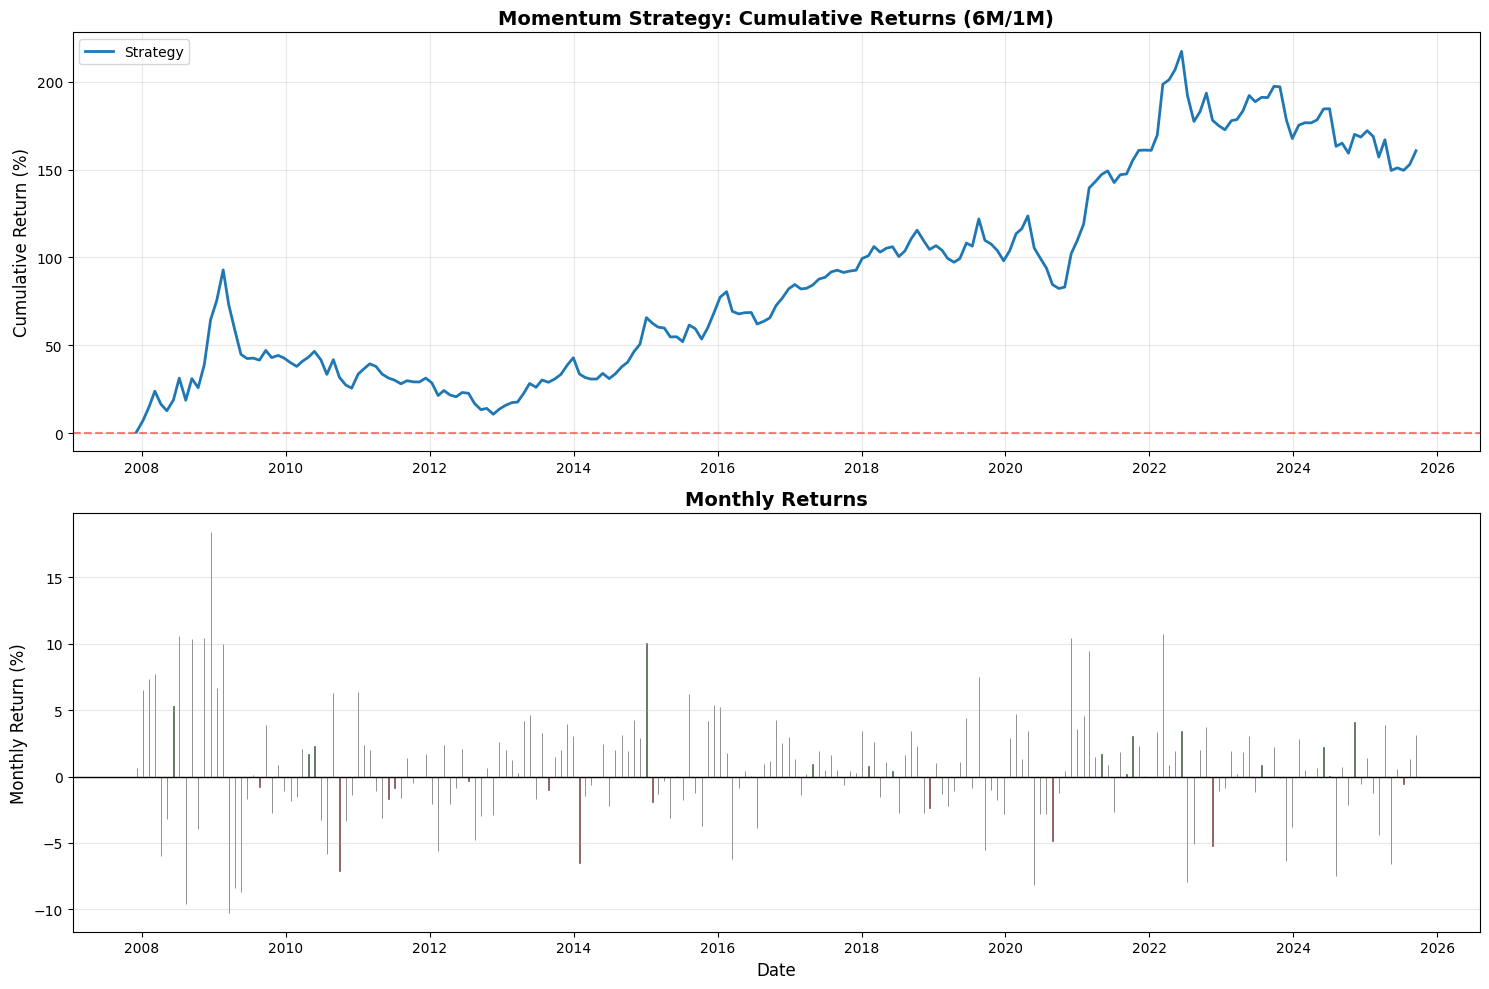

In [ ]:
'''
Jegadeesh-Titman Momentum Strategy for ETF Baskets
Proper implementation with overlapping portfolios
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from dateutil.relativedelta import relativedelta
import requests
from bs4 import BeautifulSoup
import re
import webbrowser
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

# Parameters
FORMATION_PERIOD = 12  # months to look back
HOLDING_PERIOD = 1    # months to hold
NUM_WINNERS = 50
NUM_LOSERS = 50

def prepare_data(baskets, start_date):
    """Download and prepare ETF data"""
    df = yf.download(baskets, start=start_date)['Close']
    df.index = df.index.tz_localize(None)

    # Calculate monthly returns
    monthly_dates = []
    monthly_returns = []
    hashmap_index = {}

    current_date = df.index[0]
    prev_idx = 0
    count = 0

    for i in range(len(df)):
        if df.index[i] >= current_date + relativedelta(months=1):
            # Calculate returns for each ETF
            returns_month = []
            for col in range(len(df.columns)):
                ret = (df.iloc[i, col] - df.iloc[prev_idx, col]) / df.iloc[prev_idx, col]
                returns_month.append(ret)

            monthly_returns.append(returns_month)
            monthly_dates.append(df.index[i])
            hashmap_index[count] = i

            current_date = df.index[i]
            prev_idx = i
            count += 1

    returns_array = np.array(monthly_returns)
    return df, returns_array, hashmap_index, monthly_dates


def momentum_strategy(df, returns, hashmap_index, num_winners=NUM_WINNERS, num_losers=NUM_LOSERS):
    n_months = len(returns)
    strategy_returns = []

    for t in range(FORMATION_PERIOD, n_months):

        month_return = 0
        n_active = 0


        for lag in range(HOLDING_PERIOD):
            formation_month = t - lag

            if formation_month < FORMATION_PERIOD:
                continue


            lookback_returns = returns[formation_month-FORMATION_PERIOD:formation_month, :]
            cumulative_returns = np.prod(lookback_returns + 1, axis=0) - 1

            # Filter out NaN values
            valid_mask = ~np.isnan(cumulative_returns)
            valid_returns = cumulative_returns[valid_mask]
            valid_indices = np.where(valid_mask)[0]

            if len(valid_returns) < num_winners + num_losers:
                continue  # Skip if not enough valid stocks

            sorted_indices = np.argsort(valid_returns)
            winners = valid_indices[sorted_indices[-num_winners:]]
            losers = valid_indices[sorted_indices[:num_losers]]

            # Use nanmean as backup protection
            winner_ret = np.nanmean(returns[t, winners])
            loser_ret = np.nanmean(returns[t, losers])


            portfolio_ret = winner_ret - loser_ret
            month_return += portfolio_ret
            n_active += 1

        # Average across all active portfolios
        if n_active > 0:
            month_return /= n_active

        strategy_returns.append(month_return)

    return np.array(strategy_returns)


def calculate_metrics(returns, dates):
    """Calculate performance metrics"""
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    sharpe = mean_ret / std_ret if std_ret > 0 else 0

    # Annualized
    ann_ret = mean_ret * 12
    ann_vol = std_ret * np.sqrt(12)
    ann_sharpe = sharpe * np.sqrt(12)

    # Cumulative
    cumulative = np.cumprod(1 + returns) - 1
    total_ret = cumulative[-1]

    # Win rate
    win_rate = np.sum(returns > 0) / len(returns)

    print("=" * 60)
    print("MOMENTUM STRATEGY PERFORMANCE")
    print("=" * 60)
    print(f"Formation Period: {FORMATION_PERIOD} months")
    print(f"Holding Period: {HOLDING_PERIOD} month(s)")
    print(f"Long: Top {NUM_WINNERS} | Short: Bottom {NUM_LOSERS}")
    print(f"\nPeriod: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
    print(f"Number of Months: {len(returns)}")
    print("-" * 60)
    print(f"Mean Monthly Return: {mean_ret*100:.2f}%")
    print(f"Monthly Volatility: {std_ret*100:.2f}%")
    print(f"Monthly Sharpe: {sharpe:.4f}")
    print("-" * 60)
    print(f"Annualized Return: {ann_ret*100:.2f}%")
    print(f"Annualized Volatility: {ann_vol*100:.2f}%")
    print(f"Annualized Sharpe: {ann_sharpe:.4f}")
    print("-" * 60)
    print(f"Cumulative Return: {total_ret*100:.2f}%")
    print(f"Win Rate: {win_rate*100:.1f}%")
    print("=" * 60)

    return {
        'mean': mean_ret,
        'std': std_ret,
        'sharpe': sharpe,
        'ann_sharpe': ann_sharpe,
        'cumulative': total_ret,
        'win_rate': win_rate
    }
def get_500():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/123.0.0.0 Safari/537.36"
        )
    }
    resp = requests.get(url, headers = headers)

    soup = BeautifulSoup(resp.text, "html.parser")
    # print(resp)
    table = soup.find("table", {'id': "constituents"})

    tr_tags = table.find_all("tr")

    all_companies = []
    for i in range(1, len(tr_tags)):
        tds = tr_tags[i].find_all('td')
        if len(tds) > 0:
            ticker = tds[0].text.strip()
            if ticker == 'BRK.B' or ticker == 'BF.B':
              continue
            all_companies.append(ticker)

    return all_companies

def plot_results(dates, returns):
    """Plot strategy performance"""
    cumulative = np.cumprod(1 + returns) - 1

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Cumulative returns
    ax1.plot(dates, cumulative * 100, linewidth=2)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax1.set_title(f'Momentum Strategy: Cumulative Returns ({FORMATION_PERIOD}M/{HOLDING_PERIOD}M)',
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend([f'Strategy'], loc='upper left')

    colors = ['green' if r > 0 else 'red' for r in returns]
    ax2.bar(dates, returns * 100, color=colors, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_title('Monthly Returns', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Monthly Return (%)', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


def main():

    baskets = get_500()
    start_date = "2010-05-01"

    df, returns, hashmap_index, monthly_dates = prepare_data(baskets, start_date)

    strategy_returns = momentum_strategy(
        df, returns, hashmap_index,
        num_winners=NUM_WINNERS,
        num_losers=NUM_LOSERS
    )


    strategy_dates = monthly_dates[FORMATION_PERIOD:]


    metrics = calculate_metrics(strategy_returns, strategy_dates)


    plot_results(strategy_dates, strategy_returns)

    return strategy_returns, strategy_dates, metrics


if __name__ == "__main__":
  returns, dates, metrics = main()
